# Predicting the sale price of bulldozers using machine learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition

> How well can we predict the future sale price  of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the github repo of Daniel Bourke's as a zip file.

There are 3 main datasets:-

- Train.csv - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including SalePrice which is the target variable).
- Valid.csv - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as Train.csv).
- Test.csv - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the SalePrice attribute, as this is what we'll be trying to predict).

## 3. Evaluation

The evaluation metric for this is the RMSLE (root mean squared log error) between actual and predicted auction prices.

Note:- The goal for most regression evalaution metrics is to minimise the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view it on Google sheets:

https://docs.google.com/spreadsheets/d/1x0vDDmSk578RiZOclKVPeMnPV7HpCFTKpGwLveLkwFU/edit?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Importing training and validating sets

In [2]:
df=pd.read_csv('./data/bluebook-for-bulldozers/TrainAndValid.csv',
               low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
# rows and columns in the DataFrame
df.shape

(412698, 53)

In [5]:
# checking missing values
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [6]:
# columns in DataFrame
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [7]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

Now we explore columns by plotting (one of the most important columns) sale date and sale price(target column) since this is a time series dataset. Instead of plotting all rows, we just plot the first 1000rows.

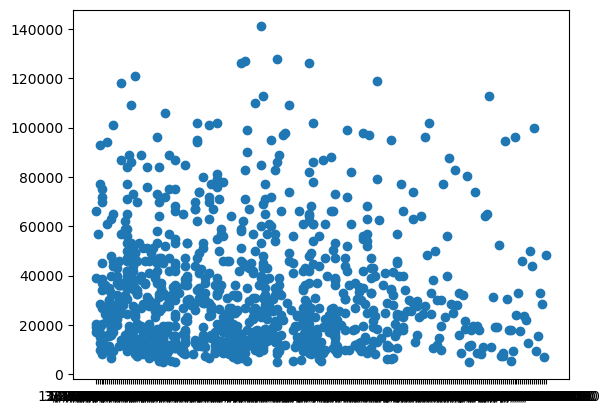

In [8]:
fig,ax=plt.subplots()
ax.scatter(df.saledate[:1000],df.SalePrice[:1000])

Now look at the distributions of few columns in the DataFrame.

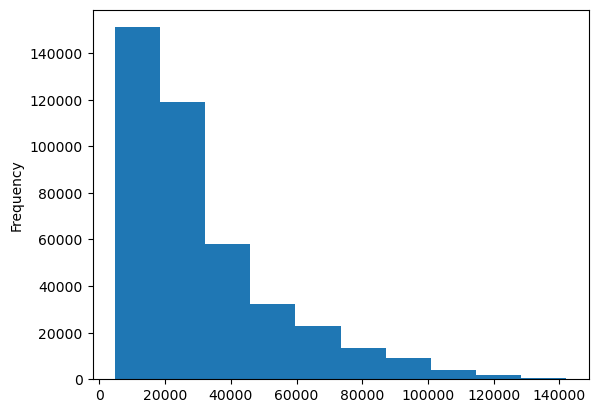

In [9]:
df.SalePrice.plot.hist();

### Parsing date

When we work with time series data, we want to enrich the time and date components as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

Initially, the saledate column is of object type

In [10]:
df.saledate.dtype

dtype('O')

In [11]:
# import data again but this time time parse dates
df=pd.read_csv('./data/bluebook-for-bulldozers/TrainAndValid.csv',
               low_memory=False,
               parse_dates=['saledate'])

In [12]:
df.saledate.dtype

dtype('<M8[ns]')

In [13]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

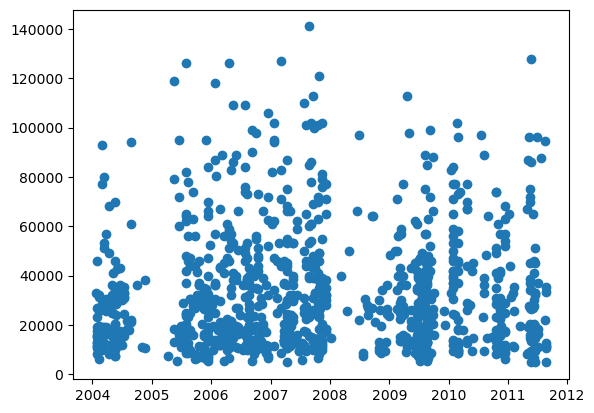

In [14]:
# now plot the same figure using this parsed dates
fig,ax=plt.subplots()
ax.scatter(df.saledate[:1000],df.SalePrice[:1000])

Notice the difference between this plot and the previous plot.

Here matplotlib understands the dtypes of the columns and plots it accordingly

In [15]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


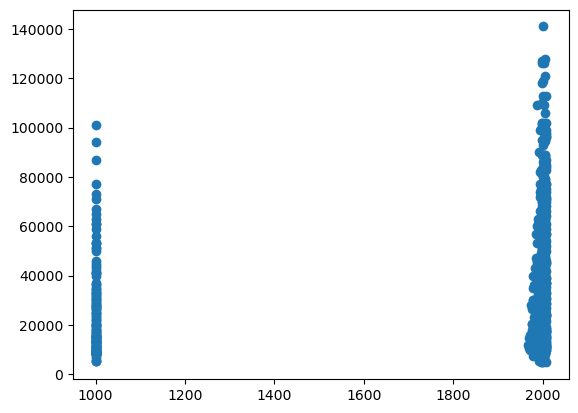

In [16]:
# plotting YearMade and SalePrice
fig,ax=plt.subplots()
ax.scatter(df.YearMade[:1000],df.SalePrice[:1000])
# ax.set_xlim(1999,2013)

In [17]:
df.YearMade.dtype

dtype('int64')

In [18]:
df.YearMade.value_counts()

YearMade
1000    39391
2005    22096
1998    21751
2004    20914
1999    19274
        ...  
1937        1
1949        1
1947        1
2012        1
2013        1
Name: count, Length: 73, dtype: int64

In [19]:
# to see every column without trancating the columns in middle
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [20]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [21]:
# sort DataFrame in date order
df.sort_values(by=['saledate'],inplace=True,ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [22]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


Now we've got our date in order.

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [23]:
# make a copy
df_tmp=df.copy()

In [24]:
# changes made to df_tmp, will not affect the original df
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add a datetime parameter for `saledate` column(aka feature engineering)

This should be done for every time series dataset.

Add a datetime column in the `df_tmp` DataFrame at the end of columns.

In [25]:
df_tmp['saleYear']=df_tmp['saledate'].dt.year
df_tmp['saleMonth']=df_tmp.saledate.dt.month
df_tmp['saleDay']=df_tmp.saledate.dt.day
df_tmp['saleDayOfTheWeek']=df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfTheYear']=df_tmp.saledate.dt.dayofyear

In [26]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [27]:
# Now we've enriched our DataFrame with date time features and we can remove it now
df_tmp.drop('saledate',axis=1,inplace=True)

In [28]:
#df_tmp.saledate

In [29]:
# check values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

We can explore columns, 

In [30]:
# let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_jobs=-1,
                            random_state=42)

# split the data
X=df_tmp.drop('SalePrice',axis=1)
y=df_tmp.SalePrice

model.fit(X,y)

ValueError: could not convert string to float: 'Low'

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [79]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

Now, since we have missing values and some columns ave datatype as object which needs to be converted into numeric in order for machine learning model to draw patterns.

### Convert all strings to categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

We'll use the `pd.api.types.is_string_dtype()` to check whether a give column in DataFrame is a string object or not.

In [76]:
df_tmp=df

In [30]:
pd.api.types.is_object_dtype(df_tmp["UsageBand"])

True

In [38]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

False

The reason I got False here eventhough the column is of object dtype is beacuse of the missing values present in that column. Therefore first impute missing values then convert (This is what I think)... No, use `pd.api.type.is_object_dtype()` instead.

In [31]:
pd.api.types.is_object_dtype(df_tmp["ProductGroup"])

True

Here, I got True, beacuse this coulmn has no missing values and is of object dtype

Therefore i'll use `if not pd.api.types.is_numeric_dtype(content)` which returns all the columns which are not numeric or you can also use `pd.api.types.is_object_dtype(content)`

In [36]:
df_tmp.items

<bound method DataFrame.items of         SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
205615  1646770     9500.0    1126363     8434         132          18.0   
274835  1821514    14000.0    1194089    10150         132          99.0   
141296  1505138    50000.0    1473654     4139         132          99.0   
212552  1671174    16000.0    1327630     8591         132          99.0   
62755   1329056    22000.0    1336053     4089         132          99.0   
...         ...        ...        ...      ...         ...           ...   
410879  6302984    16000.0    1915521     5266         149          99.0   
412476  6324811     6000.0    1919104    19330         149          99.0   
411927  6313029    16000.0    1918416    17244         149          99.0   
407124  6266251    55000.0     509560     3357         149          99.0   
409203  6283635    34000.0    1869284     4701         149          99.0   

        YearMade  MachineHoursCurrentMeter UsageBand f

In [36]:
# find the columns which cntain strings
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [39]:
# find the columns which cntain strings or objects more precisely
for label,content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


`df.items()` treats the DataFrame as a dictionary where label is column name and content is the values in the column.

Using this `if not pd.api.types.is_numeric_dtype(content)`, will return all dtype columns which are not numeric(can be used for timebeing) but it's correct to use `if pd.api.types.is_object_dtype(content)` which returns all columns with object dtype whereas `if pd.api.types.is_string_dtype(content)` is specifically used to return column which are of string dtype.

In [47]:
#This will turn all of the string values into category values
for label,content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)
        df_tmp[label]=content.astype('category').cat.as_ordered()

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


`df_tmp[label]=content.astype('category').cat.as_ordered()` 

- `content.astype('category')` : converts the column values into category dtype
- `as_ordered()` : this orders the categorical values

So what this line of code does is that, it assigns a numeric value to each category but in the code cell below, these categories still look like strings but Pandas under the hood treats them as numbers and we can check that using `df_tmp.state.cat.codes`

In [48]:
df_tmp.dtypes

SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

In [49]:
# run after filling missing values
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [50]:
# run after filling missing values
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing values.

In [46]:
df_tmp.isna().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### SAve preprocessed data 

In [2]:
# export current tmp dataframe
df_tmp.to_csv('data/bluebook-for-bulldozers/train_tmp_filled.csv',
              index=False)

NameError: name 'df_tmp' is not defined

In [3]:
df_tmp=pd.read_csv('data/bluebook-for-bulldozers/train_tmp_filled.csv',
                   low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


This export and reimport can be done at any stage.

## Fill missing values

### Fill numeric missing values first

In [51]:
# this skips the columns with missing values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfTheWeek
saleDayOfTheYear


In [52]:
df_tmp.saleYear

205615    1989
274835    1989
141296    1989
212552    1989
62755     1989
          ... 
410879    2012
412476    2012
411927    2012
407124    2012
409203    2012
Name: saleYear, Length: 412698, dtype: int32

In [53]:
# check for which numeric columns have null values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [54]:
# fill numeric rows with the median
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label+'_is_missing']=pd.isnull(content)
            # fill missing numeric values with median
            df_tmp[label]=content.fillna(content.median())

Why we added this column `df_tmp[label+'_is_missing']`, is that if we just fill up the missing values with median, there might be a reason why that missing vakue was missing. Therefore we add a binary column which tells us if a row in that column had a missing value. Here we chose, `median()` because it is more robust than the mean as mean is robust to outliers.

In [55]:
# check if there are any numeric null values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

This printed nothing, therefore we have no missing values.

In [56]:
# check how many examples were missing using the _is_missing column
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

Now we have filled all numeric missing values and now we need to fill the rest of the missing values.

### Filling and turning categorical variables into numbers

In [57]:
# ceck for columns which aren't numeric
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [58]:
# turn categorical variacbles into numbers and fill missing
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # add a binary column to indicate missing or not
        df_tmp[label+'_is_missing']=pd.isnull(content)
        # turn catehgories into numbers and add +1
        df_tmp[label]=pd.Categorical(content).codes+1

In [59]:
pd.Categorical(df_tmp.state).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [60]:
pd.Categorical(df_tmp.UsageBand).codes

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

Since this column has a lot of missing values, it's code will be filled by pandas as -1. Therefore we add +1 to codes where there is a missing value and all our numbers will be positive.

In [61]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


In [62]:
df_tmp.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=103)

In [63]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [68]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of our data is numeric as well as our dataframe has no missing values,we should be able to build a machine learning model.

In [69]:
len(df_tmp)

412698

In [71]:
%%time
from sklearn.ensemble import RandomForestRegressor
#instantiate model
model=RandomForestRegressor(n_jobs=-1,
                            random_state=42)

# fit the model
model.fit(df_tmp.drop('SalePrice',axis=1),df_tmp['SalePrice'])

CPU times: total: 22min 43s
Wall time: 6min 38s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
# score the model

model.score(df_tmp.drop('SalePrice',axis=1),df_tmp.SalePrice)

**Question:** Why doesn't metric hold water? i.e (why isn't the metric reliable)

### Splitting data into train/validation sets
(to better evaluate our model)

Why did we import trainandvalid.csv instead of importing the separately. Its because, since this is a time-series dataset, Daniel wanted to show us how to create our own valid set instead of using that defined valid set.

In [72]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [4]:
#we can use the year column to split into train and valid sets
# we split our data such all the rows upto 2011 belong to train set and those after that are valid test

df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [5]:
# split data into train and valid sets
df_val=df_tmp[df_tmp.saleYear==2012]
df_train=df_tmp[df_tmp.saleYear!=2012]

In [6]:
len(df_train),len(df_val)

(401125, 11573)

In [7]:
# split data into X and y
X_train,y_train=df_train.drop('SalePrice',axis=1),df_train.SalePrice
X_valid,y_valid=df_val.drop('SalePrice',axis=1),df_val.SalePrice

X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [27]:
# create evaluatio function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error,r2_score

def rmsle(y_test,y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

# create function to evaluate model on a few differnet levels
def show_scores(model):
    train_preds=model.predict(X_train)
    val_preds=model.predict(X_valid)
    scores={'Training MAE':mean_absolute_error(y_train,train_preds),
            'Valid MAE':mean_absolute_error(y_valid,val_preds),
            'Training RMSLE':rmsle(y_train,train_preds),
            'Valid RMSLE':rmsle(y_valid,val_preds),
            'Training R^2':r2_score(y_train,train_preds),
            'Valid R^2': r2_score(y_valid,val_preds)}
    return scores

**If our model is performing better on our validation dataset, it means that the model is overfitting the dataset and we might want to see a sightly worse score on the validation set than on the train set.**

**Always incude evaluation functions like the above n your projects They are very helpful**

## Testing our model on a subset (to tune the hyperparameters)

In [11]:
# this takes a lot of time to run

# %%time
# model=RandomForestRegressor(n_jobs=-1,
#                             random_state=42)
# model.fit(X_train,y_train)

In [12]:
len(X_train)

401125

In [13]:
# we could do this but there's a better way traning on first 10000 records
# option 1
#model.fit(X_train[:10000],y_train[:10000])

In [18]:
# option 2
# chnage max_smaples value in RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_jobs=-1,
                             random_state=42,
                            max_samples=10000)

In [19]:
%%time 
#cutting down on max number of samples each estimator can see improves training time
model.fit(X_train,y_train)

CPU times: total: 44.3 s
Wall time: 13.3 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

The default value of `max_samples` is set as None, which means every small estimator(i.e 100 estimators) will go through 401125 samples each time but we change this to 10000 which means each small estimator will go through 10000 samples instead of 401125

**This is how we cut the training time between experiments especially when we have very large samples like this dataset using the `max_samples` parameter.**

In [28]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

Here the valid error is slightly higher than the training error which means we are not overfitting the model

### Hyperparameter tuning with RandomizedSearchCV



In [34]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid={'n_estimators':np.arange(10,100,10),
         'max_depth':[None,3,5,10],
         'min_samples_split':np.arange(2,20,2),
         'min_samples_leaf':np.arange(1,20,2),
         'max_features':[0.5,1,'sqrt','auto'],
         'max_samples':[100000]}

rs_model=RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                                                  param_distributions=rf_grid,
                                                  n_iter=2,
                                                  cv=5,
                                                  verbose=True)
# fit the RandomizedSearchCV model
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\Welcome\Desktop\bulldozer-price-prediction\env\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\Welcome\Desktop\bulldozer-price-prediction\env\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\Welcome\Desktop\bulldozer-price-prediction\env\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set 

CPU times: total: 18 s
Wall time: 1min 40s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [100000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [35]:
# find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 18,
 'min_samples_leaf': 3,
 'max_samples': 100000,
 'max_features': 'sqrt',
 'max_depth': 10}

In [36]:
# evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 8672.461985872447,
 'Valid MAE': 9931.241931045972,
 'Training RMSLE': 0.3822623285013939,
 'Valid RMSLE': 0.397738340179209,
 'Training R^2': 0.7008935948384947,
 'Valid R^2': 0.7130398308356815}

### Train a model with the best hyperparameters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`

First find a bunch of hyperparameters (ideal) on a subset of the data and then train the model on full data size on the most ideal hyperarameters.

In [37]:
%%time

# most ideal hyperparameters
ideal_model=RandomForestRegressor(n_estimators=40,
                                  min_samples_split=14,
                                  min_samples_leaf=1,
                                  max_features=0.5,
                                  n_jobs=-1,
                                  max_samples=None
                                )
# fit the ideal model
ideal_model.fit(X_train,y_train)

CPU times: total: 3min 49s
Wall time: 1min 11s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [38]:
# scores for ideal model trained on all the data
show_scores(ideal_model)

{'Training MAE': 2957.7935797581927,
 'Valid MAE': 5979.417419418637,
 'Training RMSLE': 0.1448278974429936,
 'Valid RMSLE': 0.24678671508322148,
 'Training R^2': 0.958853150831286,
 'Valid R^2': 0.8811718564330443}

Compare the valid RMSLE score to check your position on the leaderboard

In [39]:
# scores on rs_model trained only on ~10000 examples
show_scores(rs_model)

{'Training MAE': 8672.461985872449,
 'Valid MAE': 9931.241931045974,
 'Training RMSLE': 0.3822623285013939,
 'Valid RMSLE': 0.397738340179209,
 'Training R^2': 0.7008935948384947,
 'Valid R^2': 0.7130398308356815}

## Make predictions on test data

In [64]:
# import the test data
df_test=pd.read_csv('./data/bluebook-for-bulldozers/Test.csv',
                    low_memory=False,
                    parse_dates=['saledate'])

In [55]:
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,NaN,NaN,2012-10-24,80NX3,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12453,6643173,2558332,21434,149,2,2005,NaN,NaN,2012-10-24,28N,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12454,6643184,2558342,21437,149,2,1000,NaN,NaN,2012-10-24,35N,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12455,6643186,2558343,21437,149,2,2006,NaN,NaN,2012-10-24,35N,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [42]:
# make predictions on the test dataset
test_preds=ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...


In [43]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [45]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

## Preprocessing the data (getting the test dataset in the same format as the training dataset)

What you do to the train dataset needs to be done with the test dataset

In [61]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df
    """

    # adding few columns using the datetime column(saledate)
    df['saleYear']=df['saledate'].dt.year
    df['saleMonth']=df.saledate.dt.month
    df['saleDay']=df.saledate.dt.day
    df['saleDayOfTheWeek']=df.saledate.dt.dayofweek
    df['saleDayOfTheYear']=df.saledate.dt.dayofyear

    # remove the saledate column
    df.drop('saledate',axis=1,inplace=True)

    # fill the numeric rows with median 
    for label,content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+'_is_missing']=pd.isnull(content)
                # fill missing numeric values with median
                df[label]=content.fillna(content.median())

        # fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"]=pd.isnull(content)
            # we add +1 to category code beacuse padas ancodes missing values as -1
            df[label]=pd.Categorical(content).codes+1
    return df

In [65]:
# process the test data
df_test=preprocess_data(df_test)

In [66]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [67]:
# make predictions on updated test data
test_preds=model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing


In [68]:
# we can find how the columns differ using sets
set(X_train.columns)-set(df_test.columns)

{'auctioneerID_is_missing'}

So manually add a column of the above name in the test df where all values are false since it does not have that column

In [69]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test['auctioneerID_is_missing']=False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [70]:
# make predictions on the test data
test_preds=model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


To overcome the above error, im trying the following code

`test_df = test_df[train_df.columns]`

In [72]:
df_test=df_test[df_train.drop('SalePrice',axis=1).columns]

Finally our test DataFrame has same features as out training dataframe, we can make predictions.

In [75]:
test_preds=ideal_model.predict(df_test)

In [76]:
test_preds

array([18516.15602843, 17241.29388508, 48968.50371974, ...,
       11745.64690905, 16444.48013322, 28734.23455728])

In [77]:
len(test_preds)

12457

In [78]:
# Format predictions into the same format Kaggle is after
df_preds=pd.DataFrame()
df_preds['SalesID']=df_test['SalesID']
df_preds['SalesPrice']=test_preds
df_preds

,SalesID,SalesPrice
0,1227829,18516.156028
1,1227844,17241.293885
2,1227847,48968.503720
3,1227848,71337.279754
4,1227863,53697.564690
...,...,...
12452,6643171,45007.596987
12453,6643173,12052.406174
12454,6643184,11745.646909
12455,6643186,16444.480133


In [79]:
# exprot predictions data to csv
df_preds.to_csv('./data/bluebook-for-bulldozers/test_predictions.csv')

## Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the target variable (SalePrice)

In [80]:
# find feature importance of our best model
ideal_model.feature_importances_

array([3.30781429e-02, 1.77602348e-02, 4.31050695e-02, 1.65417465e-03,
       3.32519906e-03, 1.99579074e-01, 3.27240253e-03, 9.78191442e-04,
       4.25452081e-02, 5.35315293e-02, 6.21631703e-02, 4.47636726e-03,
       1.48368261e-02, 1.60534887e-01, 4.26586182e-02, 5.92511555e-03,
       2.45912460e-03, 2.89602351e-03, 2.80303699e-03, 7.51603080e-02,
       4.76957599e-04, 4.49734446e-05, 1.22009818e-03, 1.74473475e-04,
       1.40087834e-03, 2.15871199e-05, 2.98282097e-04, 5.75822821e-03,
       2.25569661e-03, 3.22253693e-03, 4.74986130e-03, 4.80314199e-03,
       3.02541569e-03, 5.95337368e-04, 3.55573033e-04, 5.56060676e-03,
       1.20820209e-03, 1.32018128e-02, 2.56756015e-03, 1.47844332e-03,
       8.09821360e-04, 8.89295224e-04, 1.65318864e-03, 6.19157187e-04,
       5.55564008e-04, 3.55015183e-04, 4.02389034e-04, 2.53729480e-03,
       9.58045675e-04, 2.16827005e-04, 3.32183013e-04, 7.25513435e-02,
       3.85699602e-03, 5.67824800e-03, 2.89454772e-03, 9.85889494e-03,
      

In [85]:
# hepler function for plotting the faeture importance
def plot_features(columns,importances,n=20):
    df=(pd.DataFrame({'features':columns,
                      'feature_importances':importances})
        .sort_values('feature_importances',ascending=False)
        .reset_index(drop=True))
    #plot the dataframe
    fig,ax=plt.subplots()
    ax.barh(df['features'][:n],df['feature_importances'][:n])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()

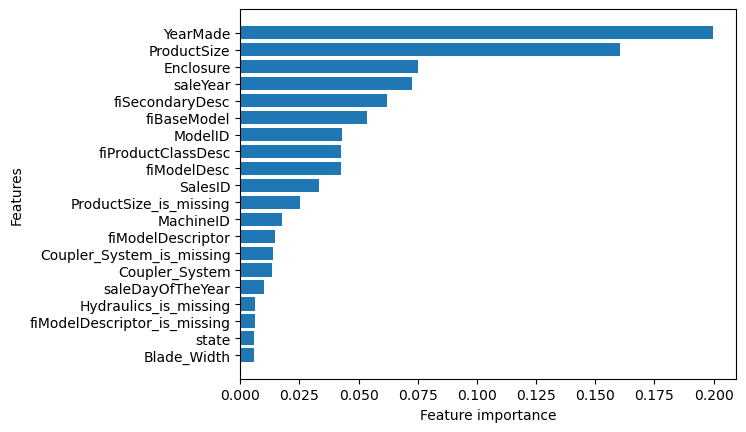

In [86]:
plot_features(X_train.columns,ideal_model.feature_importances_)

In [87]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


**Queston to finish** Why might knowing the feature importnaces of a rained ml model be heplful?

**Final Challenge** Use another model using the sklearn map or catboost or xgboost